In [1]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append('../src_jobs/')

In [2]:
import pickle
from itertools import repeat
from pathlib import Path
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import torch
from artifact import Saw_centered
from detector import SlidingWindowTransformerDetector

from data import CachedArtifactDataset, TestArtifactDataset, CenteredArtifactDataset

/opt/miniconda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
torch.set_grad_enabled(False)

In [4]:
real_data_df = pd.read_pickle('/workspaces/AICoE_Ramping_Artefacts/artifactory-master/data/real/normalized_deviation_updated_TEST.pickle') 
ground_truth = pd.read_csv('/workspaces/AICoE_Ramping_Artefacts/artifactory-master/data/gt_slidingWindow_cleanedPos.csv')

In [5]:
test_width = 512

In [6]:
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential

#autheticate
credential = DefaultAzureCredential()

# Get a handle to the workspace
ml_client = MLClient.from_config(
    credential=credential,
    path="config.json",
)

Found the config file in: config.json


In [7]:
import azure.ai.ml._artifacts._artifact_utilities as artifact_utils

data_asset = ml_client.data.get("output_Train_GPU_slidingWindow", version="1")
artifact_utils.download_artifact_from_aml_uri(uri=data_asset.path, destination="./checkpoints_transformer/", datastore_operation=ml_client.datastores)
transformer_detector = SlidingWindowTransformerDetector.load_from_checkpoint("/workspaces/AICoE_Ramping_Artefacts/artifactory-master/notebooks/checkpoints_transformer/epoch=0-step=30000-v1.ckpt").cpu()

/opt/miniconda/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'act_fct' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['act_fct'])`.
  rank_zero_warn(


In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_squared_error, confusion_matrix, roc_curve
import pandas as pd
import pickle

preds_trans = list()
gt = list()

first_artifact_index = 13139
last_artifact_index = 145319

dist = test_width // 2

for center in range(first_artifact_index, last_artifact_index, 15):
    example = torch.tensor(real_data_df[0][center-dist : center+dist])

    prediction_trans = transformer_detector(example.unsqueeze(0))

    preds_trans = preds_trans + [float(prediction_trans.numpy())]
    gt = gt + [ground_truth["0"][center]]


with open('predictions.pkl', 'wb') as file:
    pickle.dump(preds_trans, file)

with open('gt.pkl', 'wb') as file:
    pickle.dump(gt, file)


In [32]:
with open('predictions.pkl', 'rb') as file:
    preds_trans = pickle.load(file)

with open('gt.pkl', 'rb') as file:
    gt = pickle.load(file)

In [9]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(gt, preds_trans)
J = precision + recall
ix = np.argmax(J)
best_thresh_pr = thresholds[ix]

In [10]:
best_thresh_pr

0.780249834060669

Text(0.5, 1.0, 'Validation Precision-Recall curve')

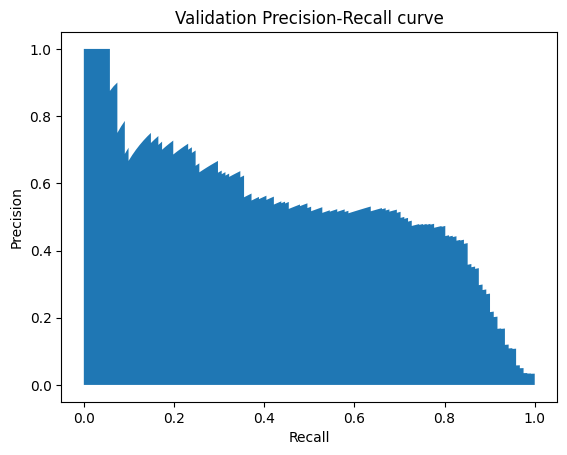

In [11]:
import matplotlib.pyplot as plt

plt.fill_between(recall, precision)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Validation Precision-Recall curve")

In [21]:
threshold = best_thresh_pr

preds_binary = [1 if value >= threshold else 0 for value in preds_trans]
tn_trans, fp_trans, fn_trans, tp_trans = confusion_matrix(gt, preds_binary, labels=[0, 1]).ravel()

metrics = pd.DataFrame([{
    'detector': 'slidingWindow_transformer',
    'accuracy': accuracy_score(gt, preds_binary),
    'precision': precision_score(gt, preds_binary),
    'recall': recall_score(gt, preds_binary),
    'mse': mean_squared_error(gt, preds_binary),
    'tn': tn_trans,
    'fp': fp_trans, 
    'fn': fn_trans, 
    'tp': tp_trans
}])

In [22]:
metrics

,detector,accuracy,precision,recall,mse,tn,fp,fn,tp
0,slidingWindow_transformer,0.982637,0.432203,0.842975,0.017363,8557,134,19,102


In [14]:
df = pd.DataFrame({
    'index': range(first_artifact_index, last_artifact_index, 15),
    'gt': gt,
    'predictions': preds_binary
})

In [15]:
# get indices of samples
fp_ind = (df.loc[(df['gt'] == 0) & (df['predictions'] == 1)])["index"]
fn_ind = (df.loc[(df['gt'] == 1) & (df['predictions'] == 0)])["index"]
tn_ind = (df.loc[(df['gt'] == 0) & (df['predictions'] == 0)])["index"]

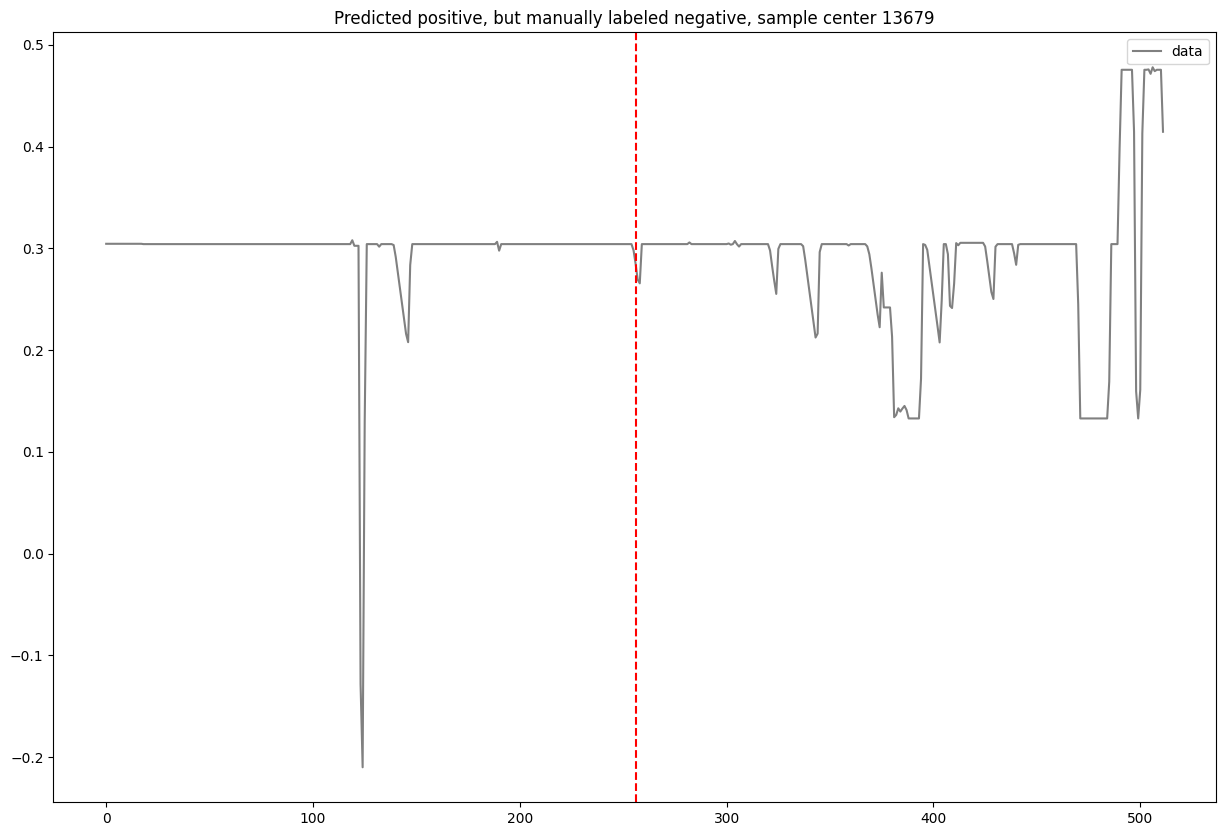

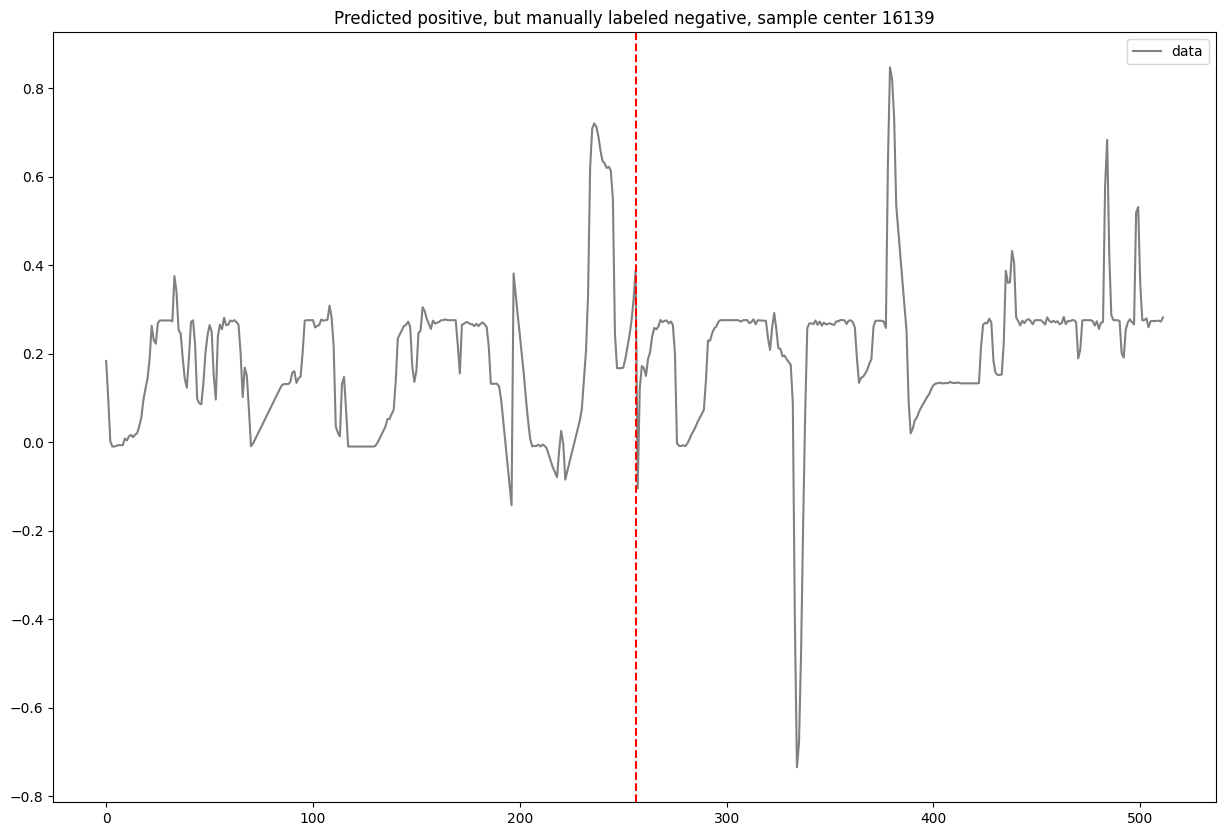

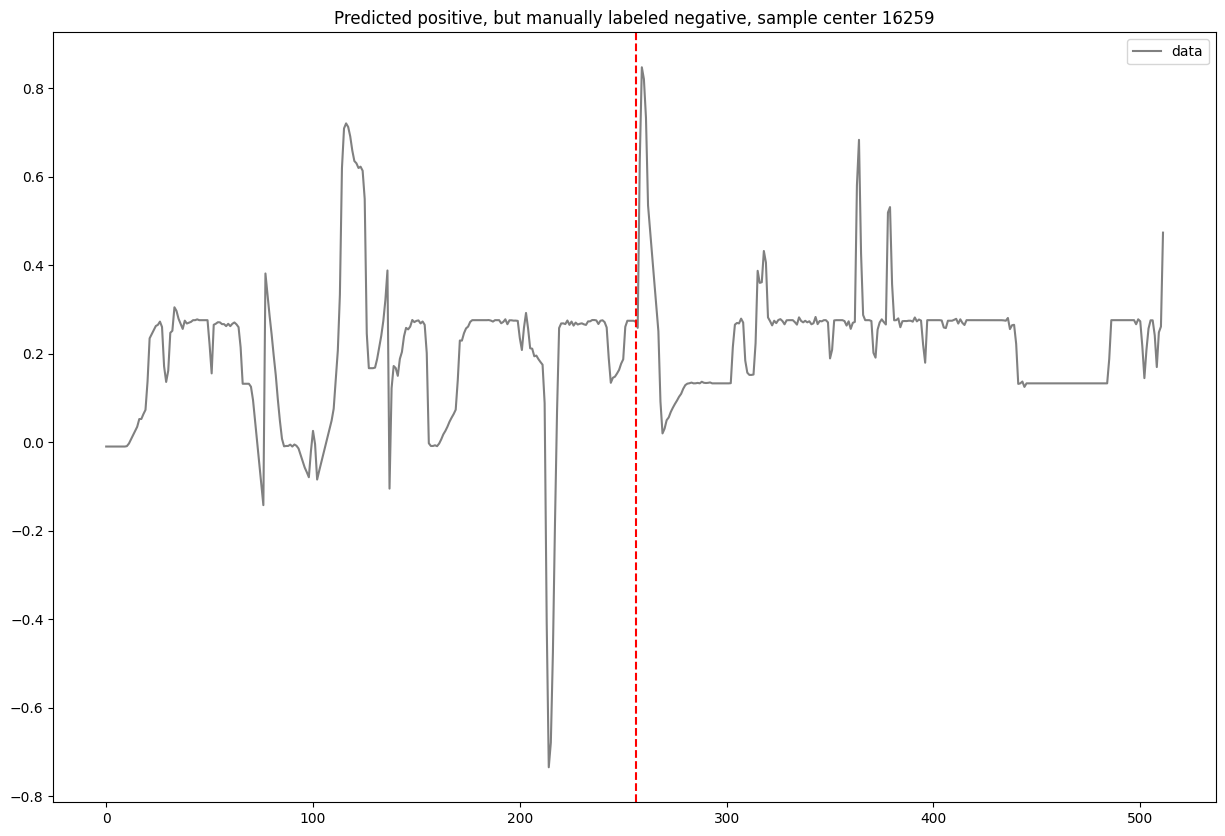

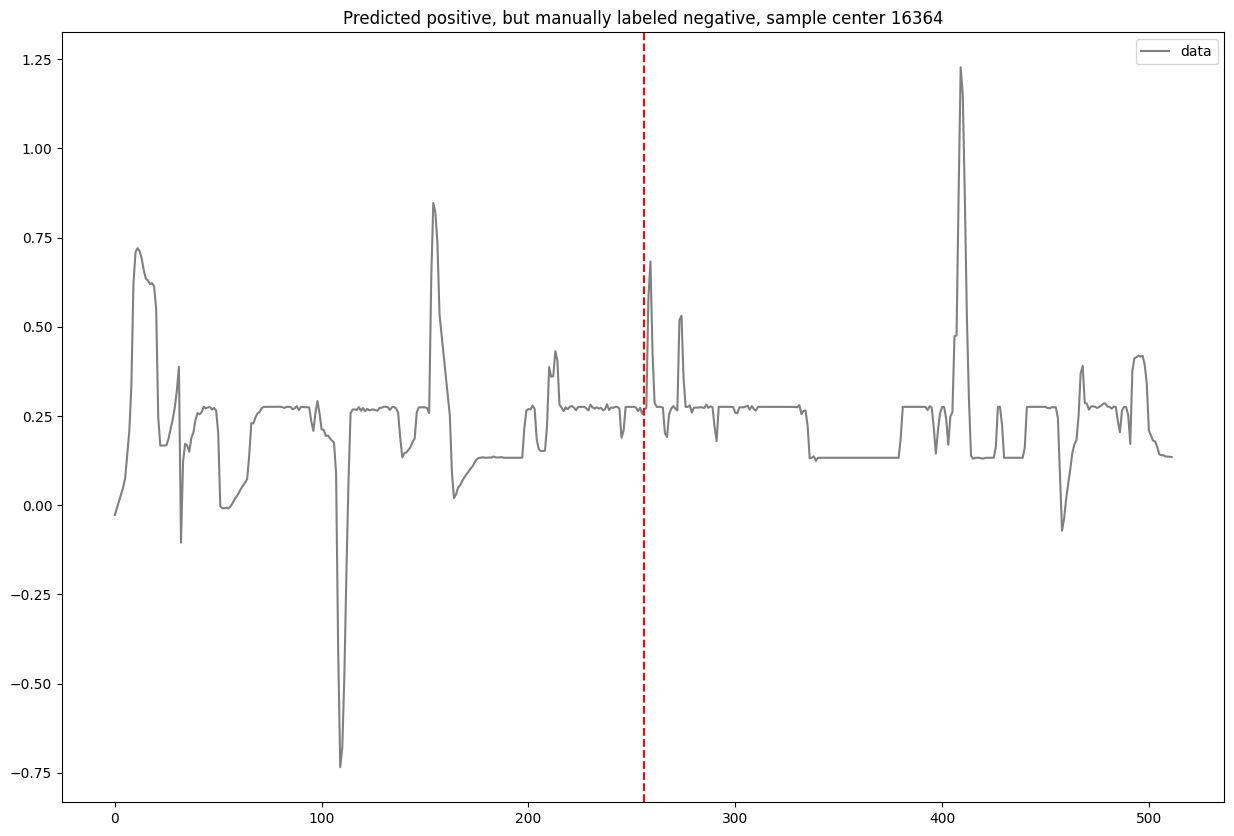

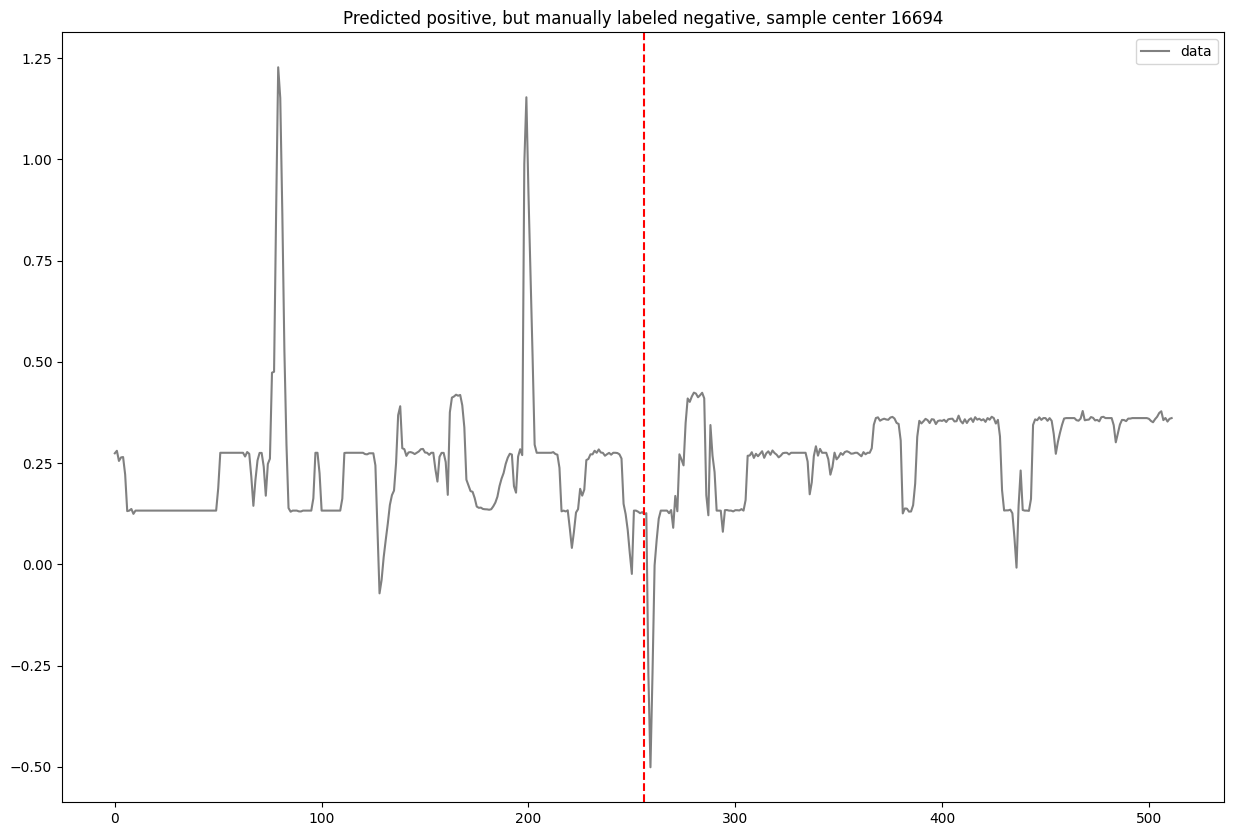

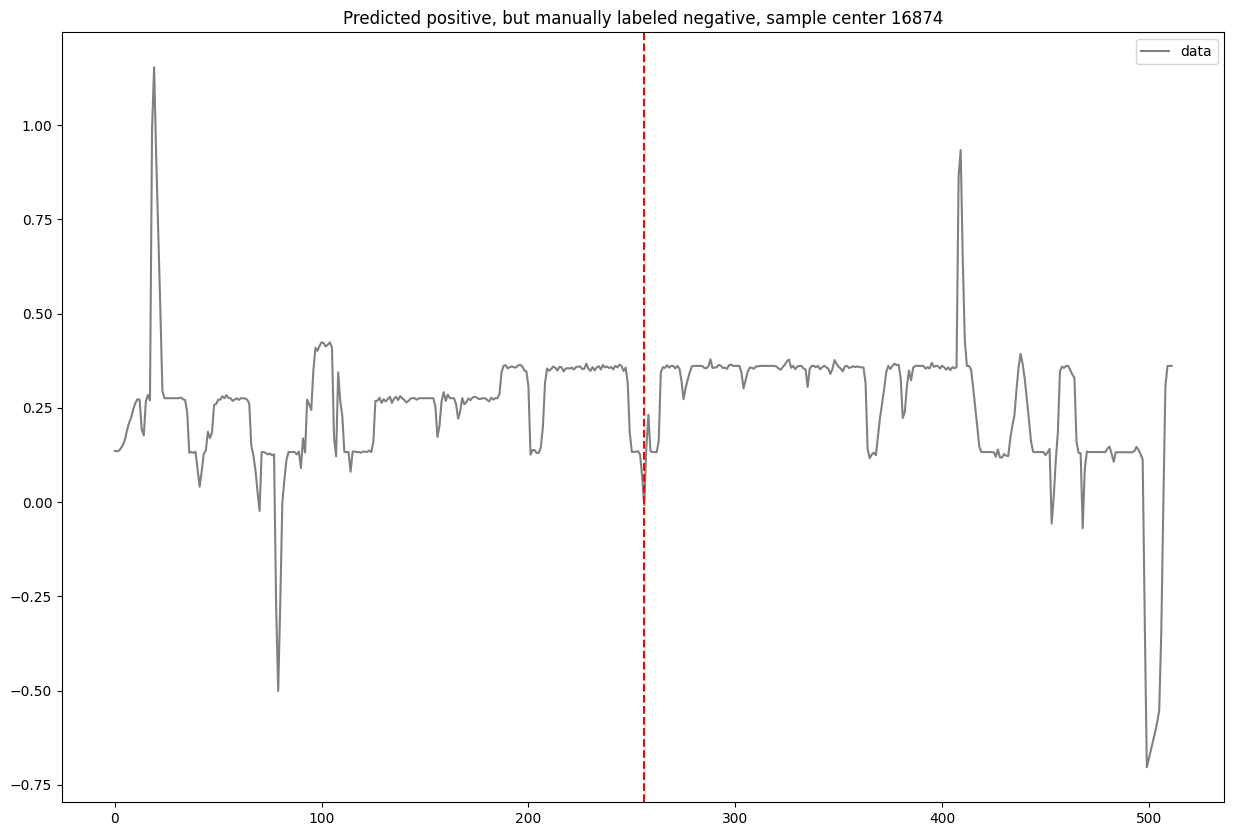

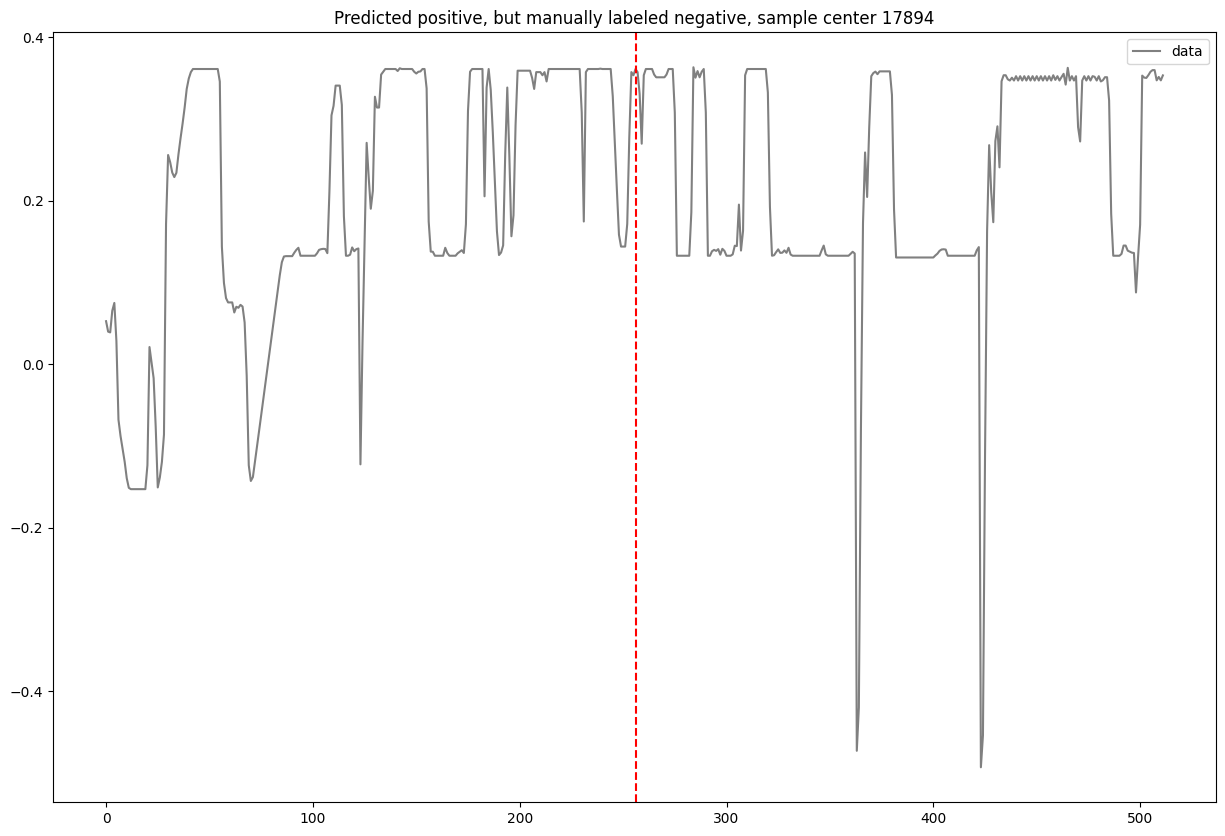

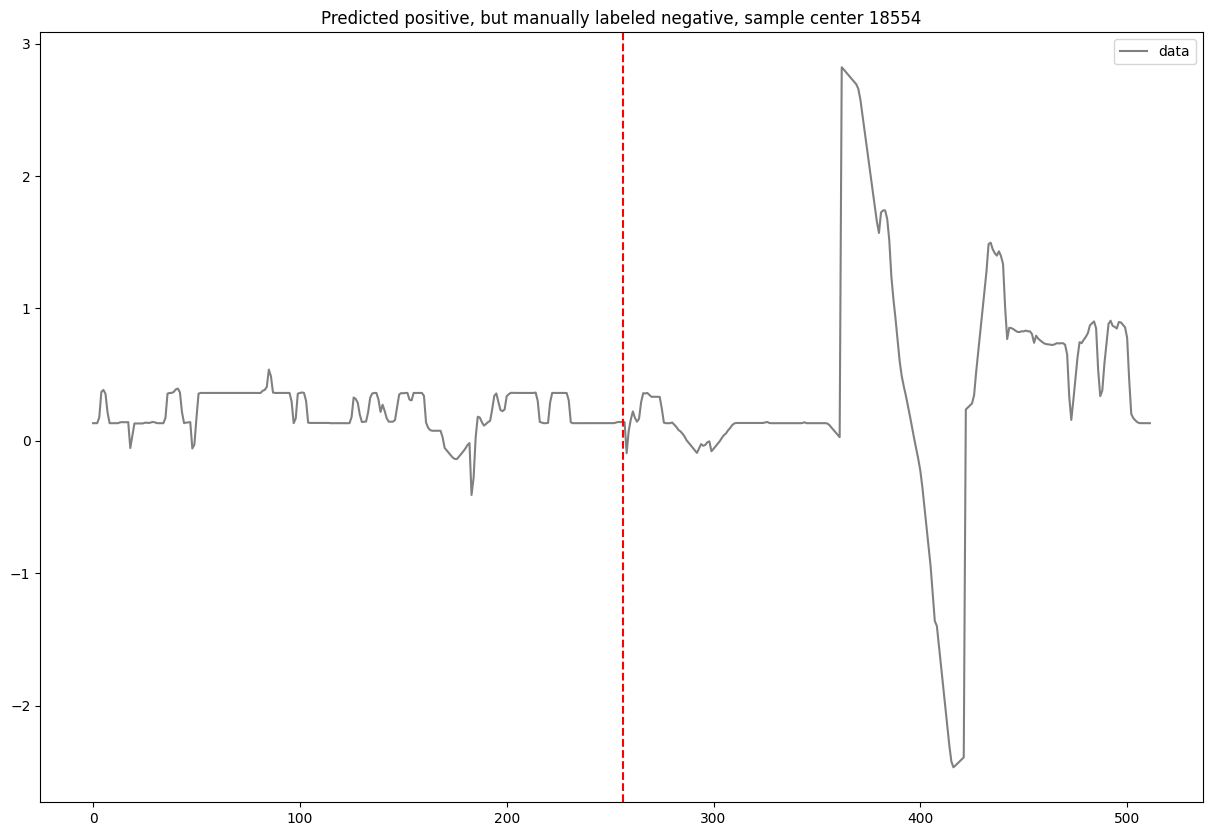

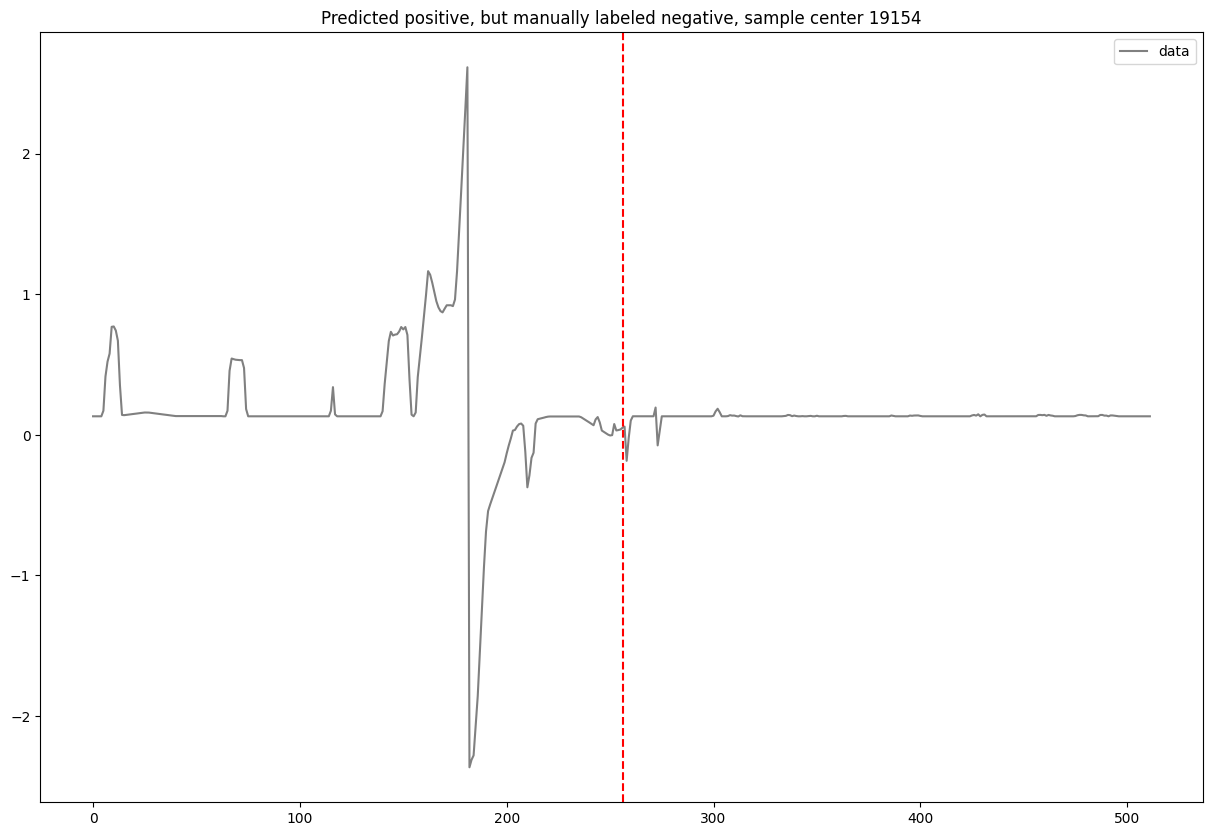

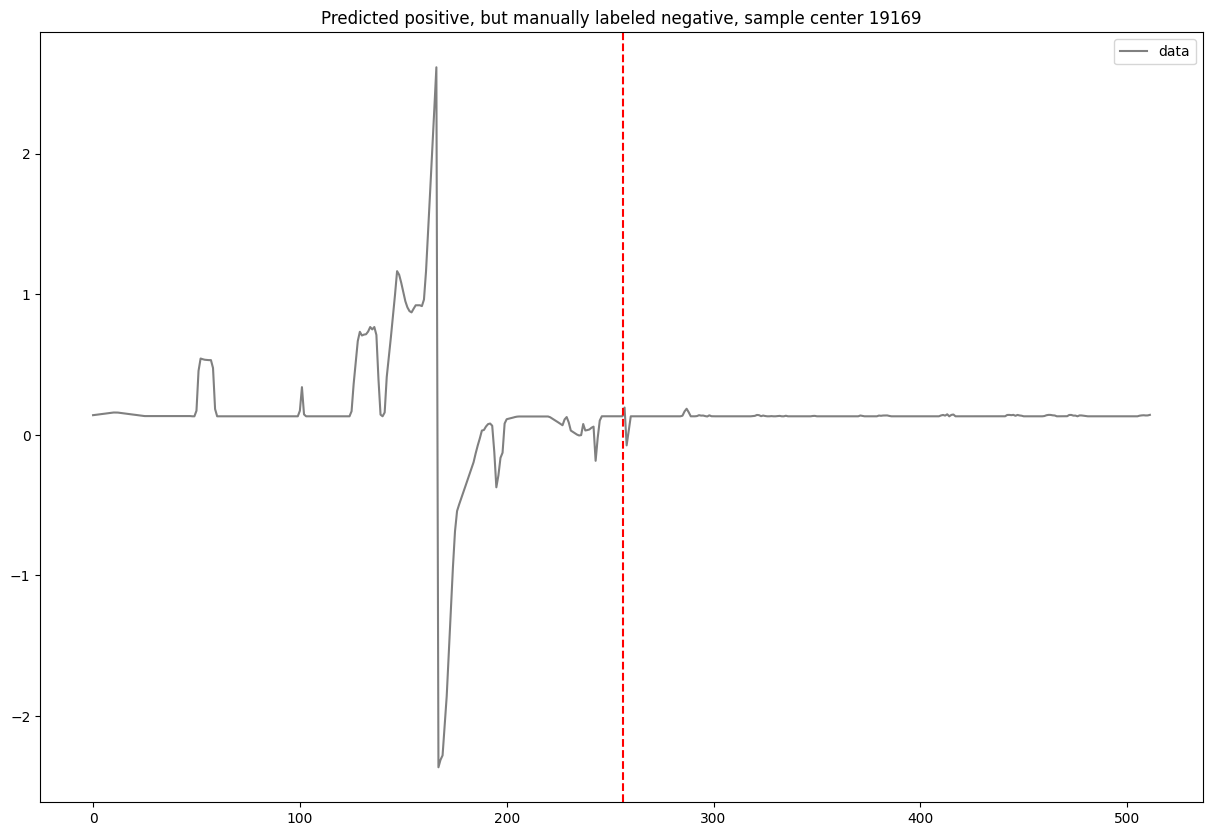

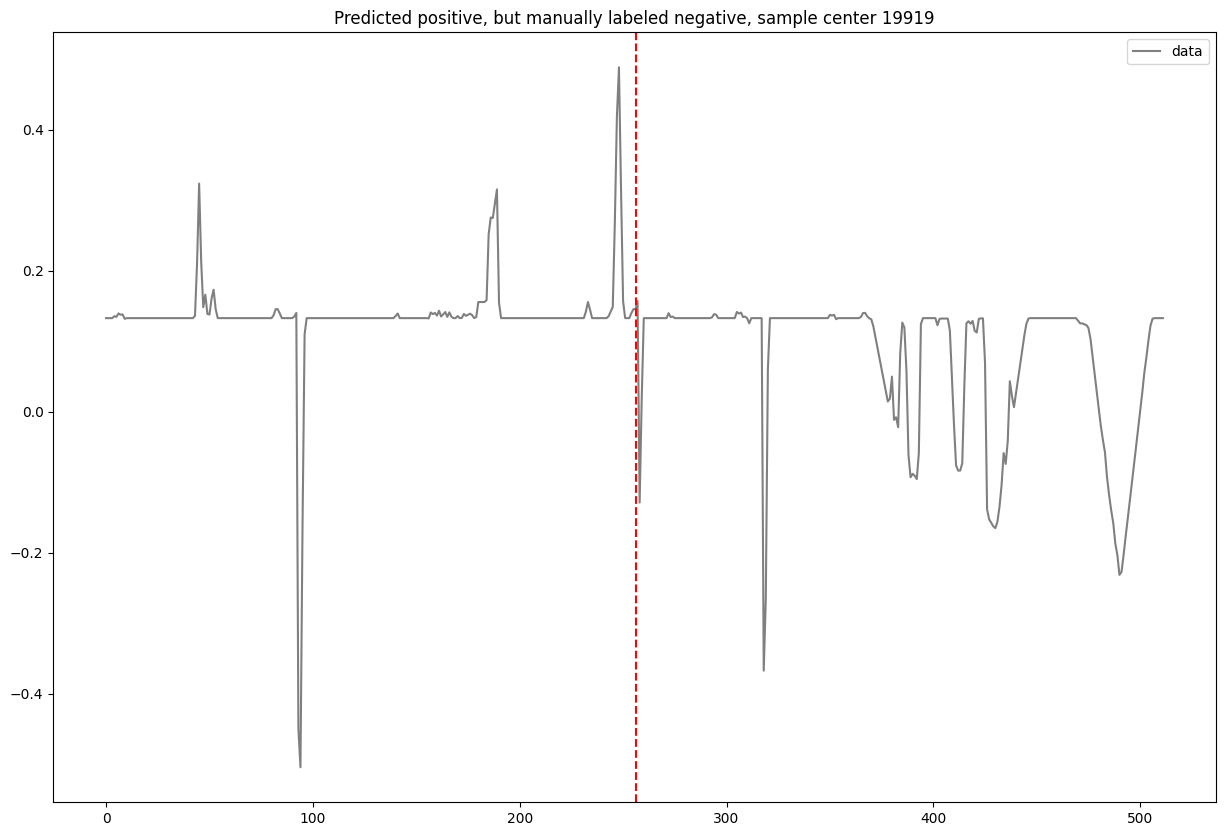

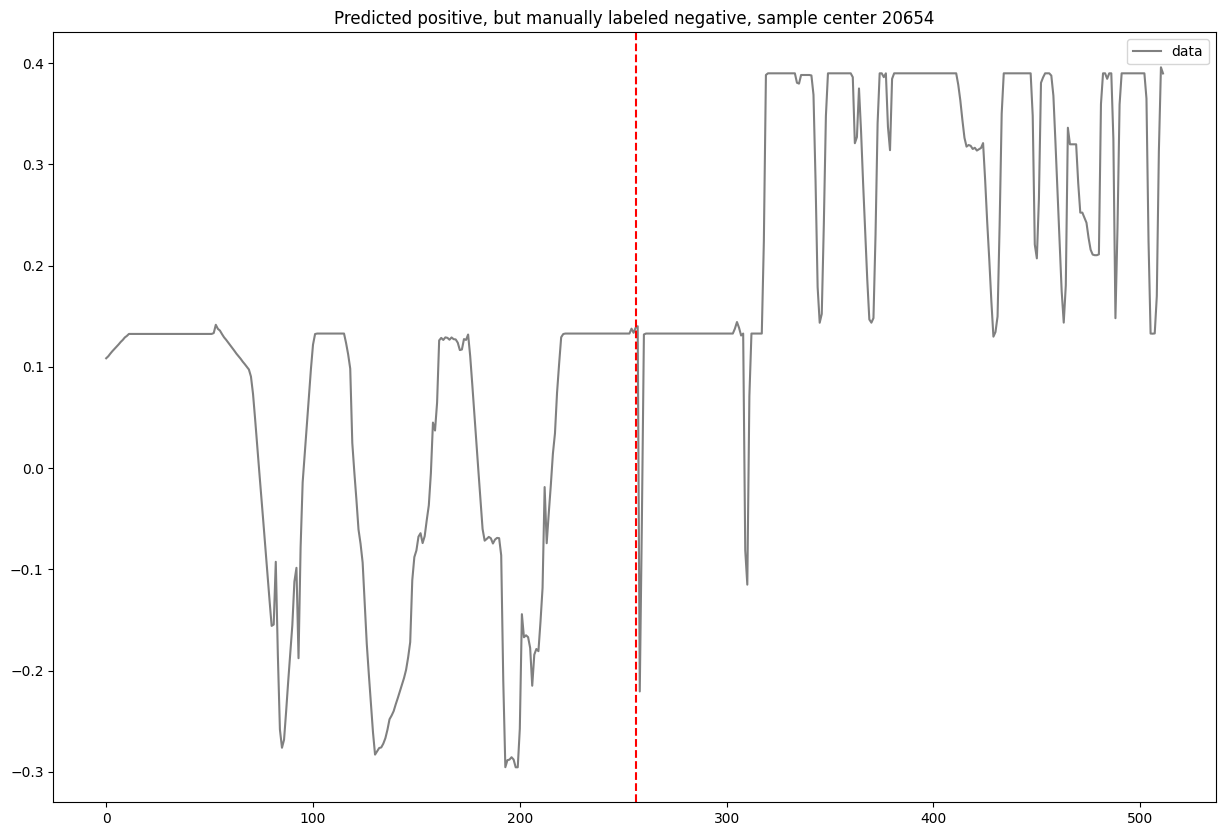

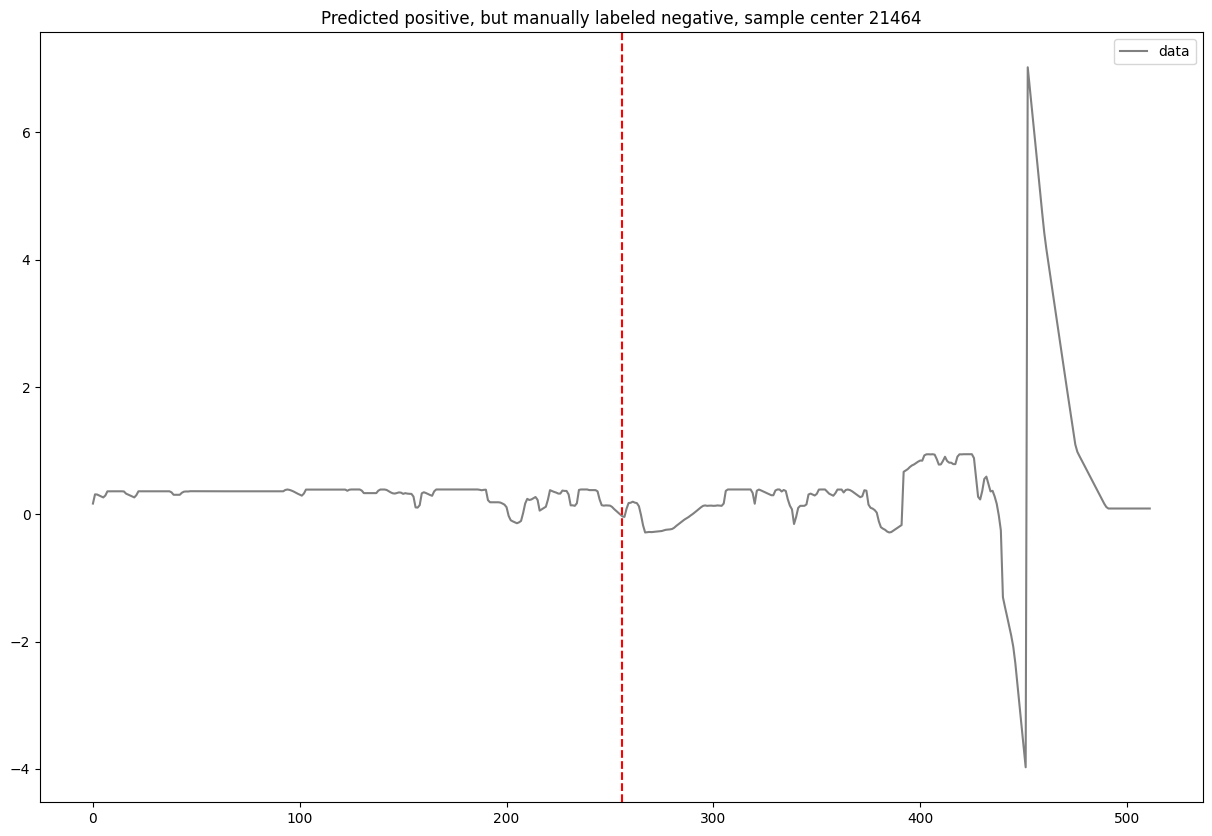

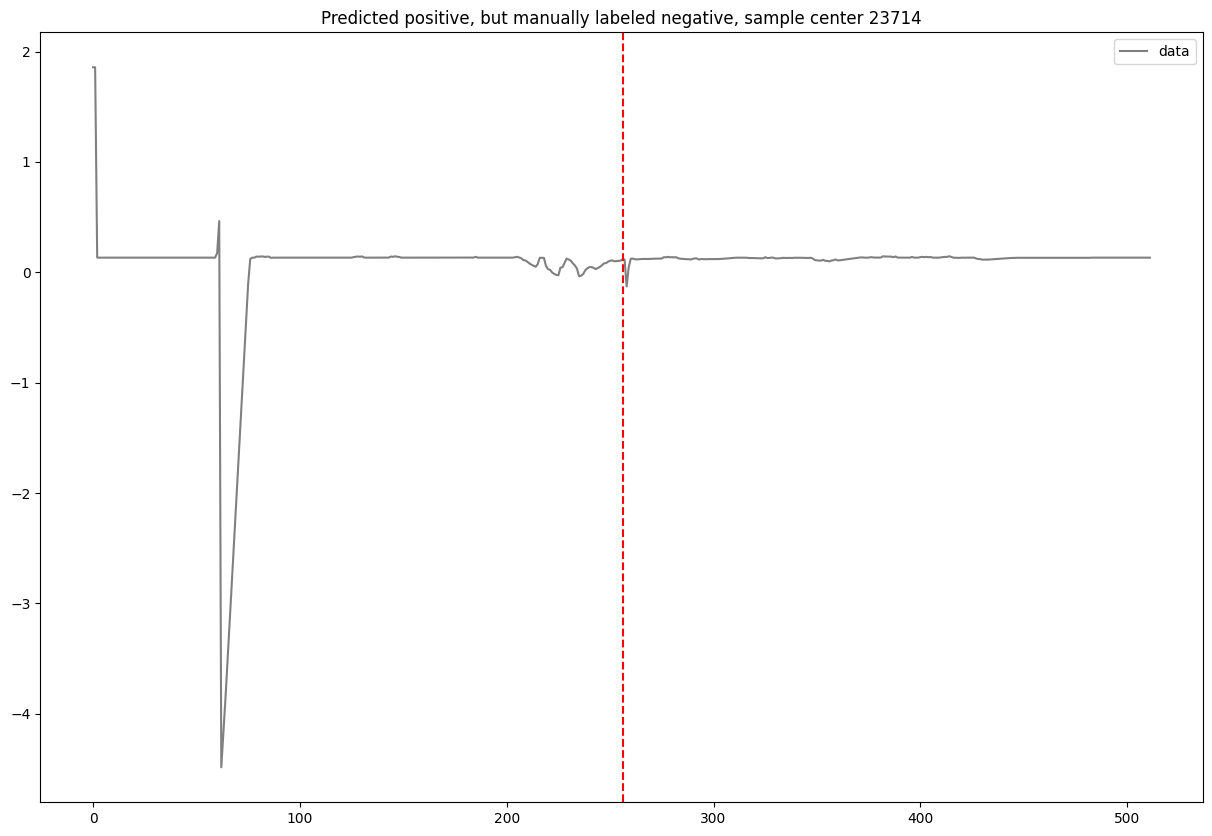

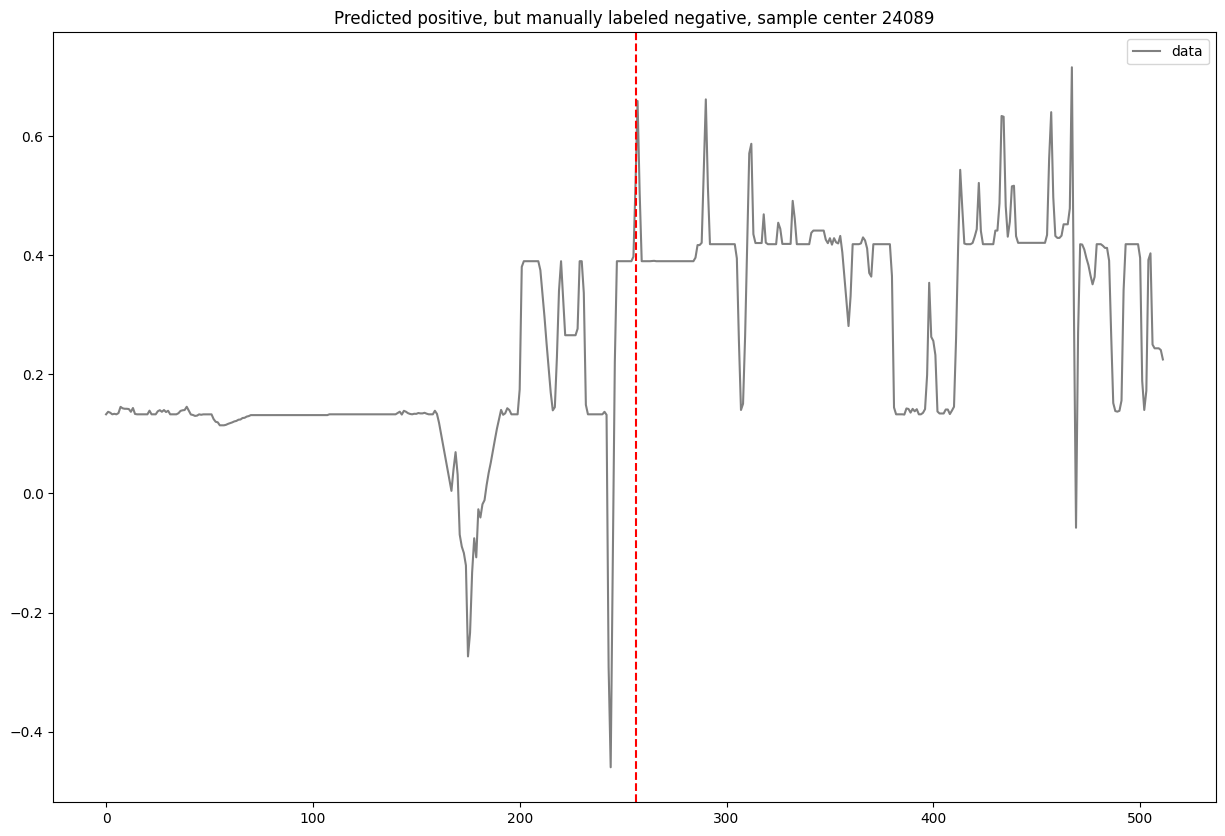

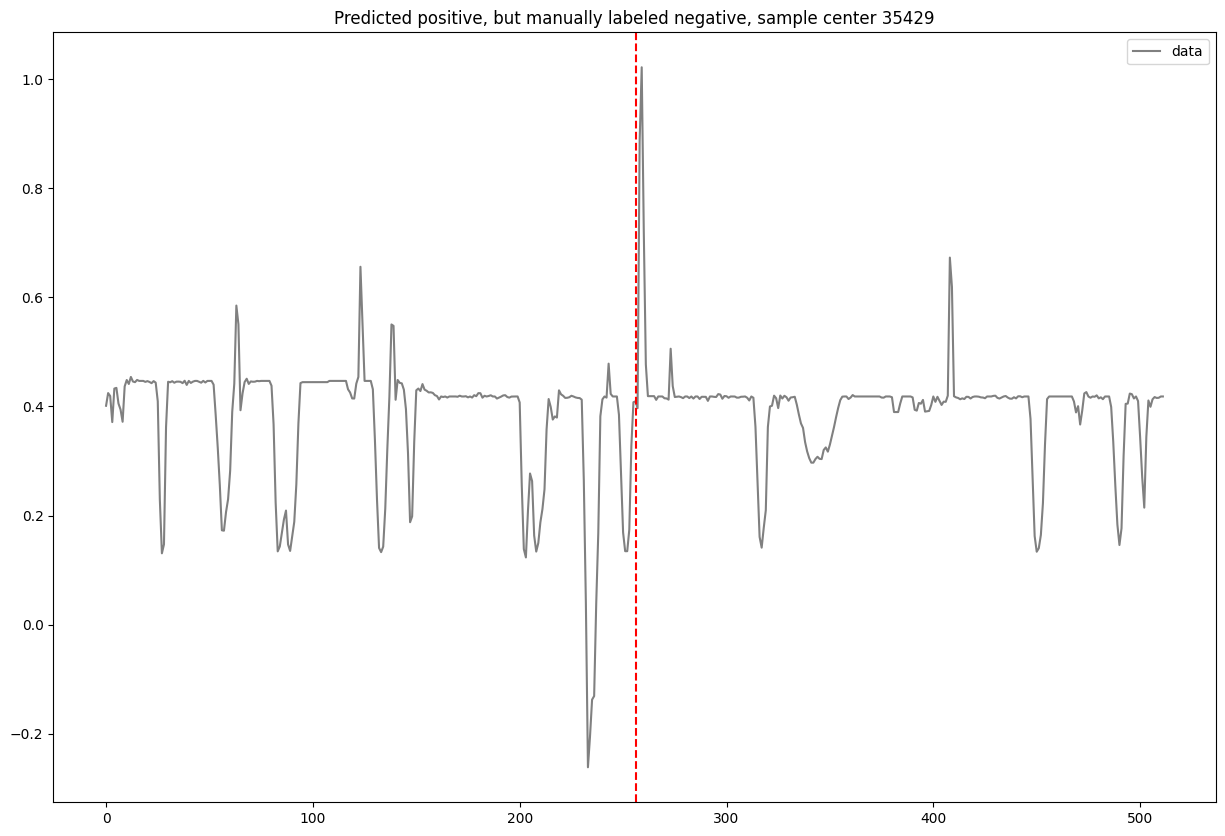

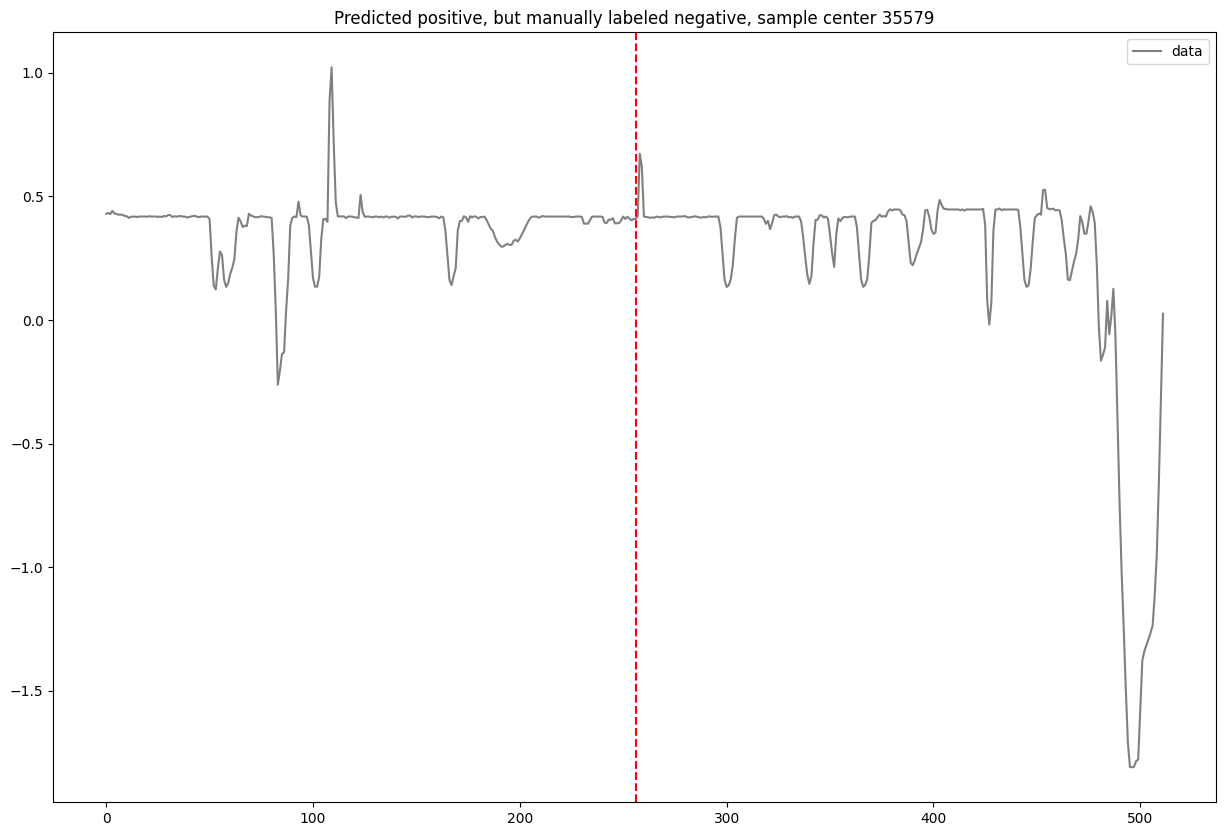

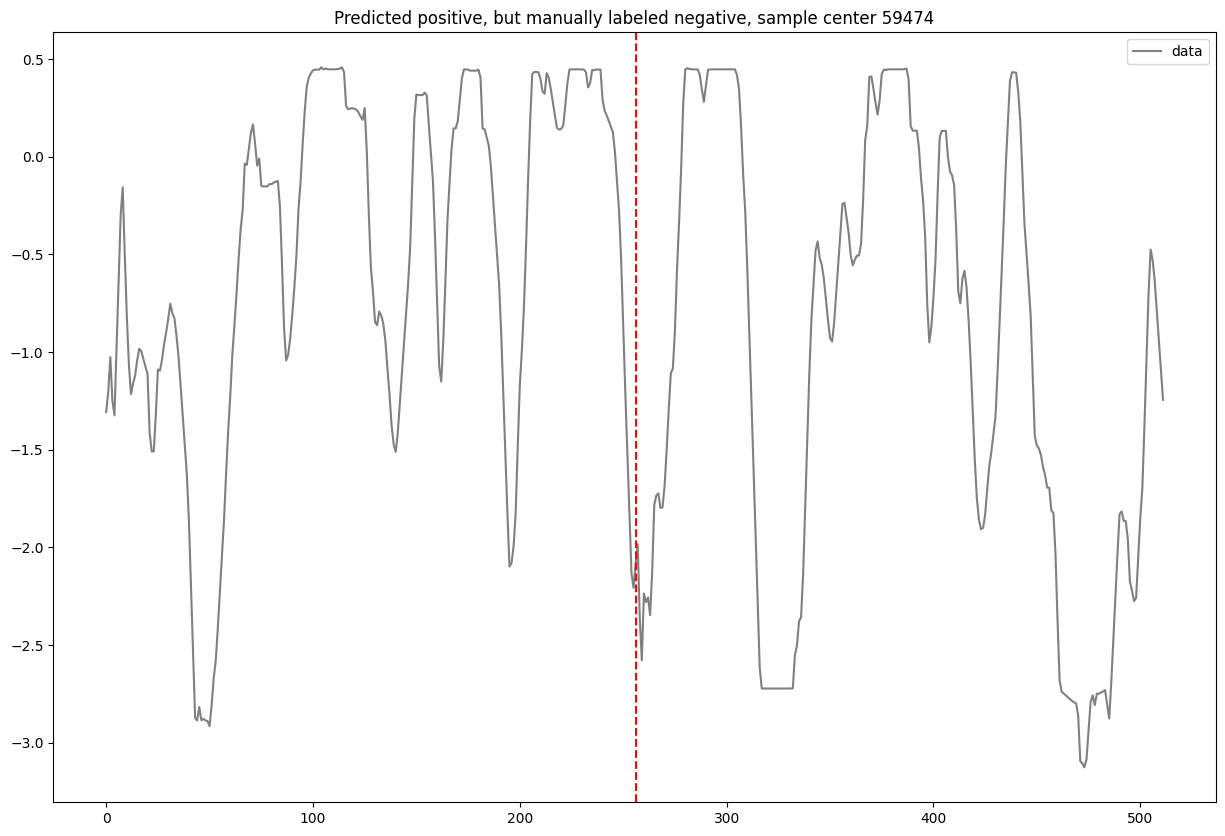

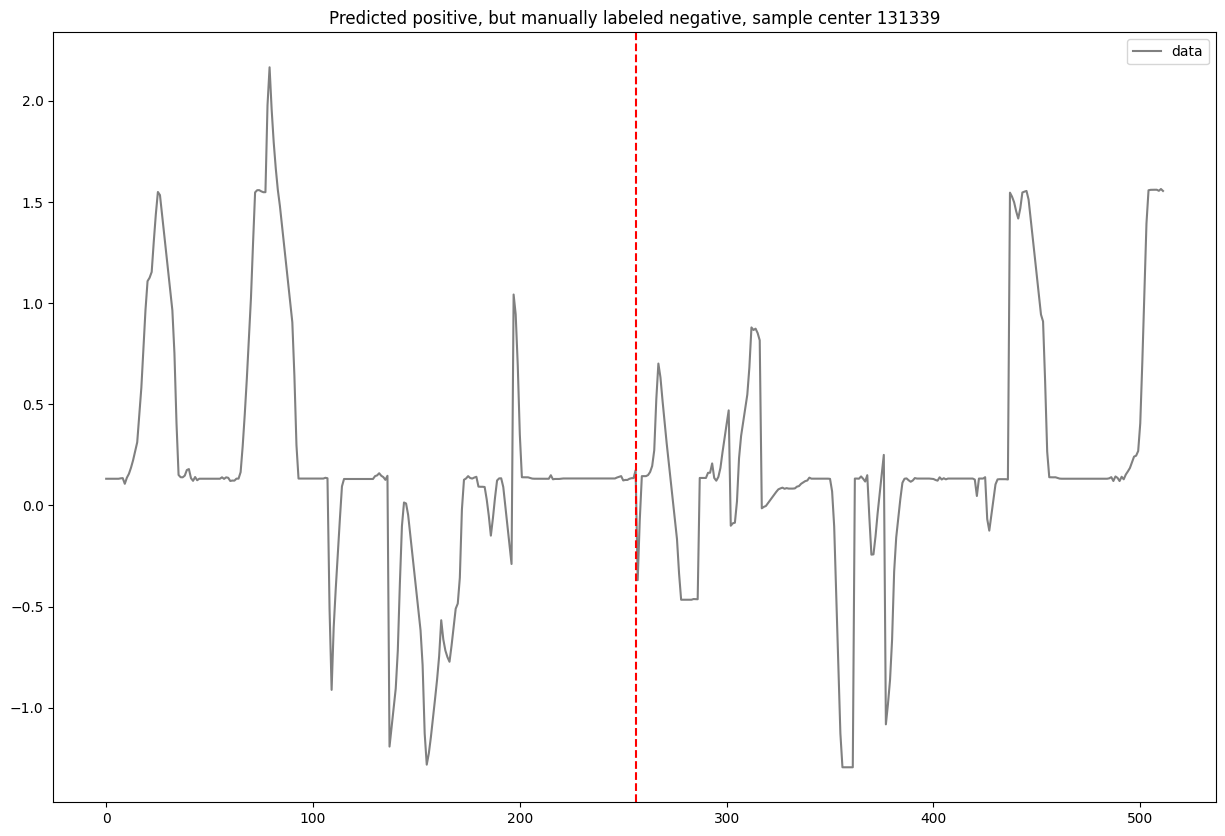

In [31]:
for index in fp_ind[:10]:
    example = torch.tensor(real_data_df[0][index-dist : index+dist])
    length  = len(example)

    prediction_trans = transformer_detector(example.unsqueeze(0))

    plt.figure(figsize=(15, 10))
    plt.plot(example, label="data", c="grey")
    plt.axvline(x=256, c="red", linestyle="--")
    plt.title(f"Predicted positive, but manually labeled negative, sample center {int(index)}")
    plt.legend()
    plt.show()